In [92]:
from dataclasses import dataclass
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import tarfile
import os
import re
import requests
from bs4 import BeautifulSoup
import csv
import unittest
import numpy as np
%matplotlib inline

# Описания классов:

In [114]:
@dataclass()
class BaseGetData:
    """Базовый класс для загрузки и обзора данных из диалоговых корпусов в репозиториях NathanDuran. 
    Схемы разметки в каждом из корпусов основаны на таксономии SWBD-DAMSL."""

    datasetName: str
    filePath: str
    columns: list
    df: pd.DataFrame

    def __init__(self, datasetName: str, filePath: str):
        self.datasetName = datasetName
        self.columns = self._getColumns(self.datasetName)
        self.filePath = filePath
        self.df = pd.read_csv(self.filePath, names = self.columns, sep = '|')

    def _getColumns(self, datasetName: str) -> list:
        """Определение колонок в таблице в зависимости от определения тегов."""
        return None
    
    def interpretData(self, n_lines: int):
        """Текстовая интерпретация данных из корпуса."""
        print("Unable to interpret this dataset")
    
    def countStats(self) -> dict:
        """Подсчет статистики по корпусу."""
        if (len(self.columns) >= 3):
            res = dict()
            dialogueAmount = 0
            path = ''
            for i in ["test", "train", "val"]:
                path = self.filePath[:self.filePath.rindex('\\') + 1] + i
                dialogueAmount += len(os.listdir(path))
            res["dialogues"] = dialogueAmount
            res["utterances"] = len(self.df["utterance"])
            res["mean_dialogue_len"] = res["utterances"] / res["dialogues"]
            return res
        else:
            return None
    
    def tagDistribution(self):
        """Визуализация распределения тегов разметки в корпусе диалогов."""
        res = dict()
        for i in self.columns[2:]:
            res[i] = Counter(self.df[i])
        for i in res.keys():
            plt.figure(figsize=(15,8))
            plt.title(i)
            plt.bar(res[i].keys(), res[i].values())
            plt.show()
    
    def _createTaxonomyCsv(self):
        """Создание csv-файла с таблицей, содержащей описания тегов разметки на основе данных из мануала SWBD-DAMSL."""
        page = requests.get("https://web.stanford.edu/~jurafsky/ws97/manual.august1.html")
        if (page.status_code != 200):
            raise Exception("Website unavailable")
        soup = BeautifulSoup(page.text, "html.parser")
        t = soup.find("table")
        k = 0
        tmp = list()
        s = ''
        stringLines = str(t.find("tr"))
        stringLines = re.sub("&lt;", '<', stringLines)
        stringLines = re.sub("\n", '', stringLines)
        stringLines = re.sub("(<\/?\w+>)\s*(<\/?\w+>)?\s*(<\/?\w+>)?", '|', stringLines)
        with open(os.getcwd() + "\\taxonomy.csv", 'w', encoding = "utf-8") as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames = ["tag", "meaning", "example", "count", '%'])
            writer.writeheader()
            for i in stringLines.split('|'):
                if ((len(i) > 0) and (i != ' ')):
                    if ((k % 5 == 0) and (k != 0)):
                        s = re.sub('\s*', '', tmp[1])
                        if (s != "SWBD"):
                            writer.writerow({"tag": s, "meaning": tmp[0], "example": tmp[2], "count": tmp[3], "%": tmp[4]})
                        tmp = list()
                    tmp.append(i)
                    k += 1
            writer.writerow({"tag": s, "meaning": tmp[0], "example": tmp[2], "count": tmp[3], "%": tmp[4]})

    def tagsMeaning(self, tagText: str) -> dict:
        """Получение описания тега разметки из таблицы в мануале (сохраненном в csv-файл)."""
        try:
            if ("taxonomy.csv" not in os.listdir(os.getcwd())):
                self._createTaxonomyCsv()
        except Exception:
            print("Извините, описание таксономии в настоящий момент недоступно.")
            return None
        else:
            with open(os.getcwd() + "\\taxonomy.csv", 'r', encoding = "utf-8") as csvfile:
                reader = csv.DictReader(csvfile)
                fldnms = reader.fieldnames
                for row in reader:
                    if (row["tag"] == tagText):
                        break
                else:
                    return None
            return row

In [115]:
class MRDACorpus(BaseGetData):
    """Класс для обзора диалогового корпуса MRDA из репозитория NathanDuran."""
    def _getColumns(self, datasetName: str) -> list:
        """Определение колонок в таблице в зависимости от определения тегов."""
        if (datasetName.lower() == "mrda"):
            return ["speaker", "utterance", "basic_tag", "general_tag", "full_tag"]
        else:
            return None

    def interpretData(self, n_lines: int):
        """Текстовая интерпретация данных из корпуса."""
        if (self.datasetName.lower() == "mrda"):
            print("Tags should be read as follows:")
            print("general_tag ^ specific_tag . disruptive_form")
            for idx, row in self.df.iterrows():
                print("{}: {} | {}^{}.{}".format(row["speaker"], row["utterance"], row["general_tag"], row["full_tag"], row["basic_tag"]))
                if (idx == n_lines - 1):
                    break
        else:
            print("Unable to interpret this dataset")

In [116]:
class SWDACorpus(BaseGetData):
    """Класс для обзора диалогового корпуса SWDA из репозитория NathanDuran."""
    def _getColumns(self, datasetName: str) -> list:
        """Определение колонок в таблице в зависимости от определения тегов."""
        if (datasetName.lower() == "swda"):
            return ["speaker", "utterance", "tag"]
        else:
            return None

    def interpretData(self, n_lines: int):
        """Текстовая интерпретация данных из корпуса."""
        if (self.datasetName.lower() == "swda"):
            for idx, row in self.df.iterrows():
                print("{}: {} | {}".format(row["speaker"], row["utterance"], row["tag"]))
                if (idx == n_lines - 1):
                    break
        else:
            print("Unable to interpret this dataset")

# Exploring MRDA:

In [2]:
!git clone https://github.com/NathanDuran/MRDA-Corpus.git

Cloning into 'MRDA-Corpus'...
Updating files:  23% (60/259)
Updating files:  24% (63/259)
Updating files:  25% (65/259)
Updating files:  26% (68/259)
Updating files:  27% (70/259)
Updating files:  28% (73/259)
Updating files:  29% (76/259)
Updating files:  30% (78/259)
Updating files:  31% (81/259)
Updating files:  32% (83/259)
Updating files:  33% (86/259)
Updating files:  34% (89/259)
Updating files:  35% (91/259)
Updating files:  36% (94/259)
Updating files:  37% (96/259)
Updating files:  38% (99/259)
Updating files:  39% (102/259)
Updating files:  40% (104/259)
Updating files:  41% (107/259)
Updating files:  42% (109/259)
Updating files:  43% (112/259)
Updating files:  43% (113/259)
Updating files:  44% (114/259)
Updating files:  45% (117/259)
Updating files:  46% (120/259)
Updating files:  47% (122/259)
Updating files:  48% (125/259)
Updating files:  49% (127/259)
Updating files:  50% (130/259)
Updating files:  51% (133/259)
Updating files:  52% (135/259)
Updating files:  53% (138

In [117]:
mrdaData = MRDACorpus("MRDA", "MRDA-Corpus\\mrda_data\\full_set.txt")

In [118]:
mrdaData.df.head()

,speaker,utterance,basic_tag,general_tag,full_tag
0,fe016,okay.,F,fg,fg
1,fe016,so um,F,fh,fh
2,fe016,i was going to try to get out of here like in ...,S,s,rt
3,fe016,um,F,fh,fh
4,fe016,because i really appreciate people coming.,S,s,s


In [119]:
print(mrdaData)

MRDACorpus(datasetName='MRDA', filePath='MRDA-Corpus\\mrda_data\\full_set.txt', columns=['speaker', 'utterance', 'basic_tag', 'general_tag', 'full_tag'], df=       speaker                                          utterance basic_tag  \
0        fe016                                              okay.         F   
1        fe016                                              so um         F   
2        fe016  i was going to try to get out of here like in ...         S   
3        fe016                                                 um         F   
4        fe016         because i really appreciate people coming.         S   
...        ...                                                ...       ...   
108197   fe041                                             great.         S   
108198   me013                                             great.         S   
108199   fe008  do we need do i need to turn something off her...         D   
108200   me013                             now these 

In [120]:
mrdaData.interpretData(15)

Tags should be read as follows:
general_tag ^ specific_tag . disruptive_form
fe016: okay. | fg^fg.F
fe016: so um | fh^fh.F
fe016: i was going to try to get out of here like in half an hour. | s^rt.S
fe016: um | fh^fh.F
fe016: because i really appreciate people coming. | s^s.S
fe016: and the main thing that i was going to ask people to help with today is to give input on what kinds of database format we should use in starting to link up things like word transcripts and annotations of word transcripts. | s^s.S
fe016: so anything that transcribers or discourse coders or whatever put in the signal with time marks for like words and phone boundaries and all the stuff we get out of the forced alignments and the recognizer. | s^e.S
fe016: so we have this um | fh^fh.D
fe016: i think a starting point is clearly the the channelized output of dave gelbart's program. | s^s.S
fe016: which don brought a copy of. | s^e.S
me011: yeah. | b^b.B
me011: yeah i'm i'm familiar with that. | s^bk.S
me011: i m

In [121]:
mrdaData.countStats()

{'dialogues': 75,
 'utterances': 108202,
 'mean_dialogue_len': 1442.6933333333334}

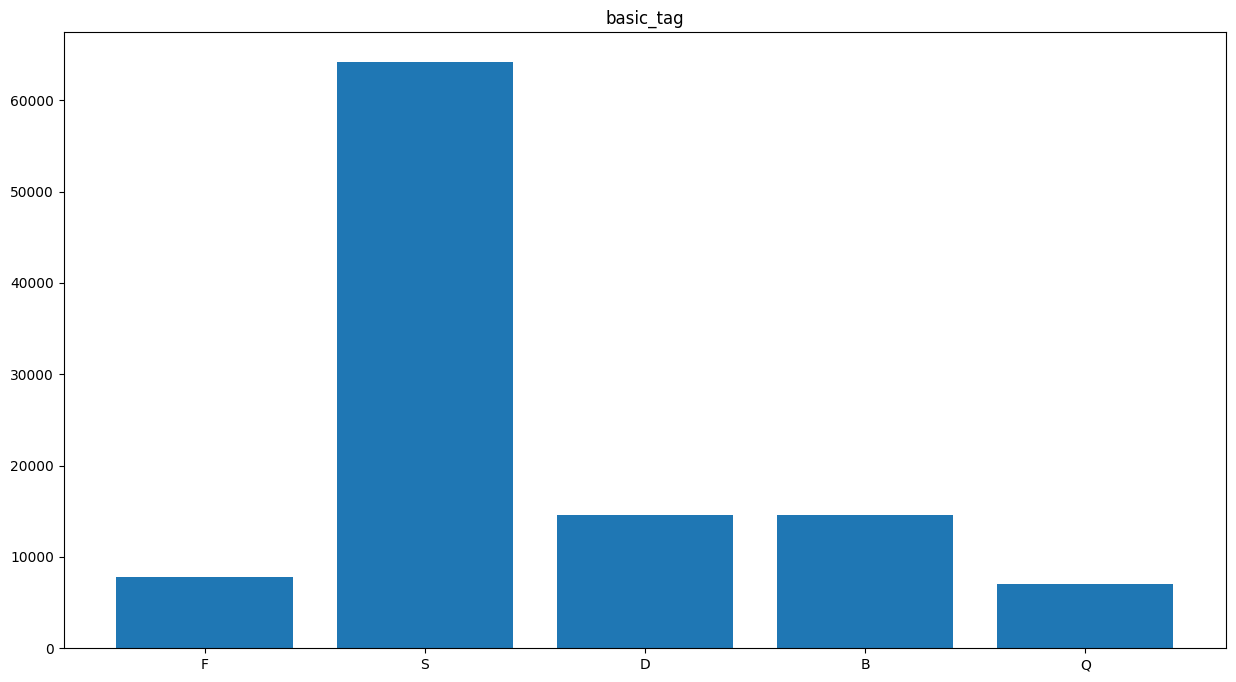

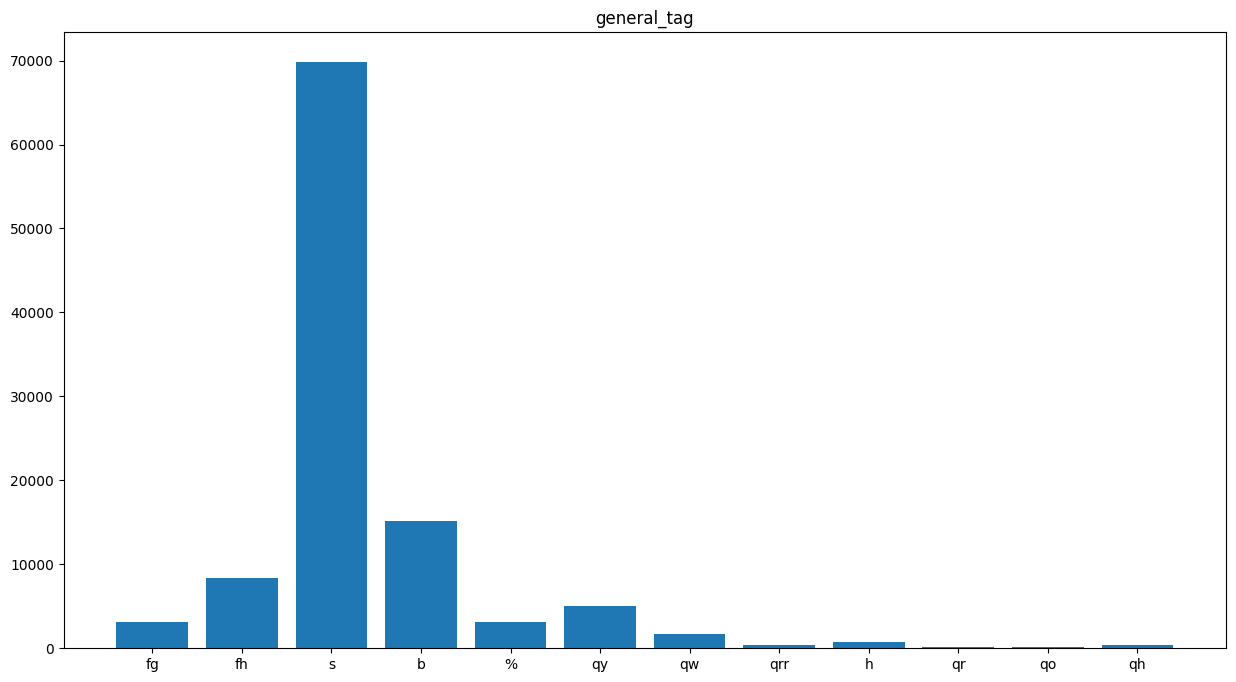

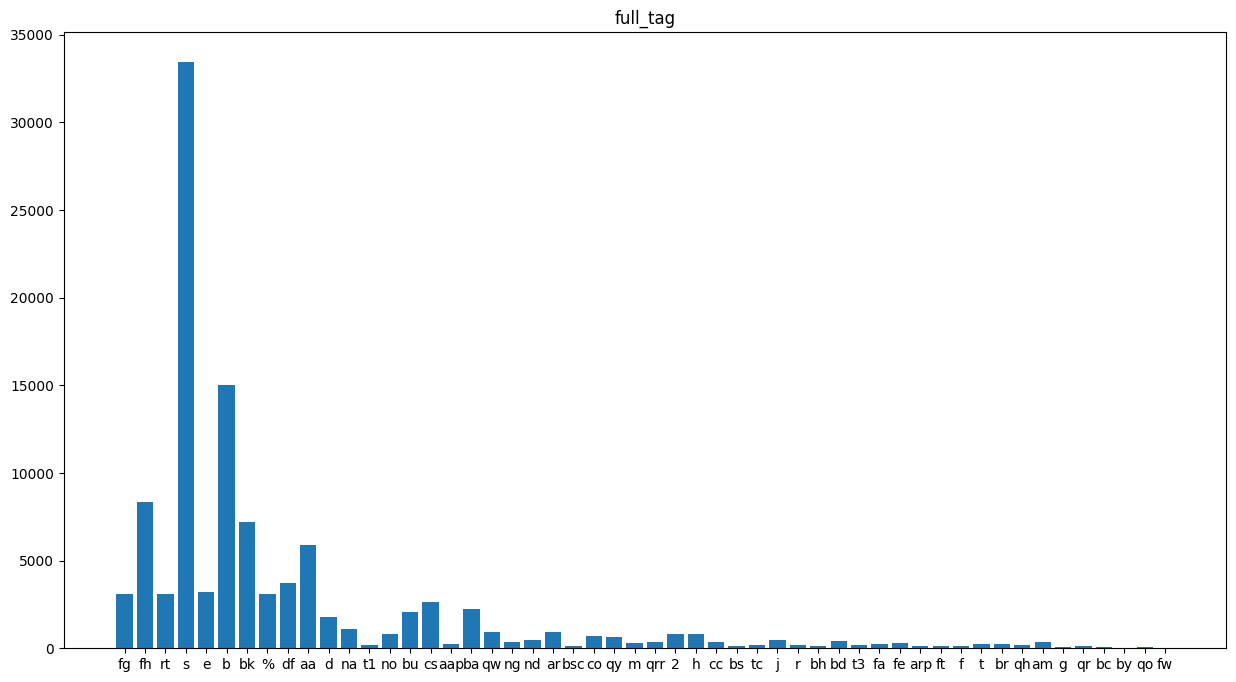

In [122]:
mrdaData.tagDistribution()

In [123]:
mrdaData.tagsMeaning("b")

{'tag': 'b',
 'meaning': 'Acknowledge (Backchannel) ',
 'example': 'Uh-huh.',
 'count': ' 37,096 ',
 '%': '19%'}

# Exploring SWDA:

In [41]:
!git clone https://github.com/NathanDuran/Switchboard-Corpus.git

fatal: destination path 'Switchboard-Corpus' already exists and is not an empty directory.


In [124]:
swdaData = SWDACorpus("SWDA", "Switchboard-Corpus\\swda_data\\full_set.txt")

In [125]:
print(swdaData)

SWDACorpus(datasetName='SWDA', filePath='Switchboard-Corpus\\swda_data\\full_set.txt', columns=['speaker', 'utterance', 'tag'], df=       speaker                                          utterance  \
0            A                                              Okay.   
1            A  So, What kind of experience do you, do you hav...   
2            B     I guess, I think, uh, I wonder if that worked.   
3            A                             Does it say something?   
4            B                           I think it usually does.   
...        ...                                                ...   
199731       B  and I know they've, there's a lot of refinerie...   
199732       B  and that, that's some pretty potent stuff they...   
199733       B             I, but I don't know how, uh, you know,   
199734       B  there's a difference in what you can smell and...   
199735       A  Be interesting to see when, as Mexico develops...   

                    tag  
0       fo_o_f

In [126]:
swdaData.df.head()

,speaker,utterance,tag
0,A,Okay.,"fo_o_fw_""_by_bc"
1,A,"So, What kind of experience do you, do you hav...",qw
2,B,"I guess, I think, uh, I wonder if that worked.",qy^d
3,A,Does it say something?,qy
4,B,I think it usually does.,sd


In [127]:
swdaData.interpretData(15)

A: Okay. | fo_o_fw_"_by_bc
A: So, What kind of experience do you, do you have, then with child care? | qw
B: I guess, I think, uh, I wonder if that worked. | qy^d
A: Does it say something? | qy
B: I think it usually does. | sd
B: You might try, uh, | ad
B: I don't know, | h
B: hold it down a little longer, | ad
B: and see if it, uh, | ad
A: Okay | aa
A: Well, Does it usually make a recording or | qy
B: Okay | b
B: I, Well, I don't remember. | sd
B: It seemed like it did, | sd
B: but it might not. | sd


In [128]:
swdaData.countStats()

{'dialogues': 1155,
 'utterances': 199736,
 'mean_dialogue_len': 172.93160173160175}

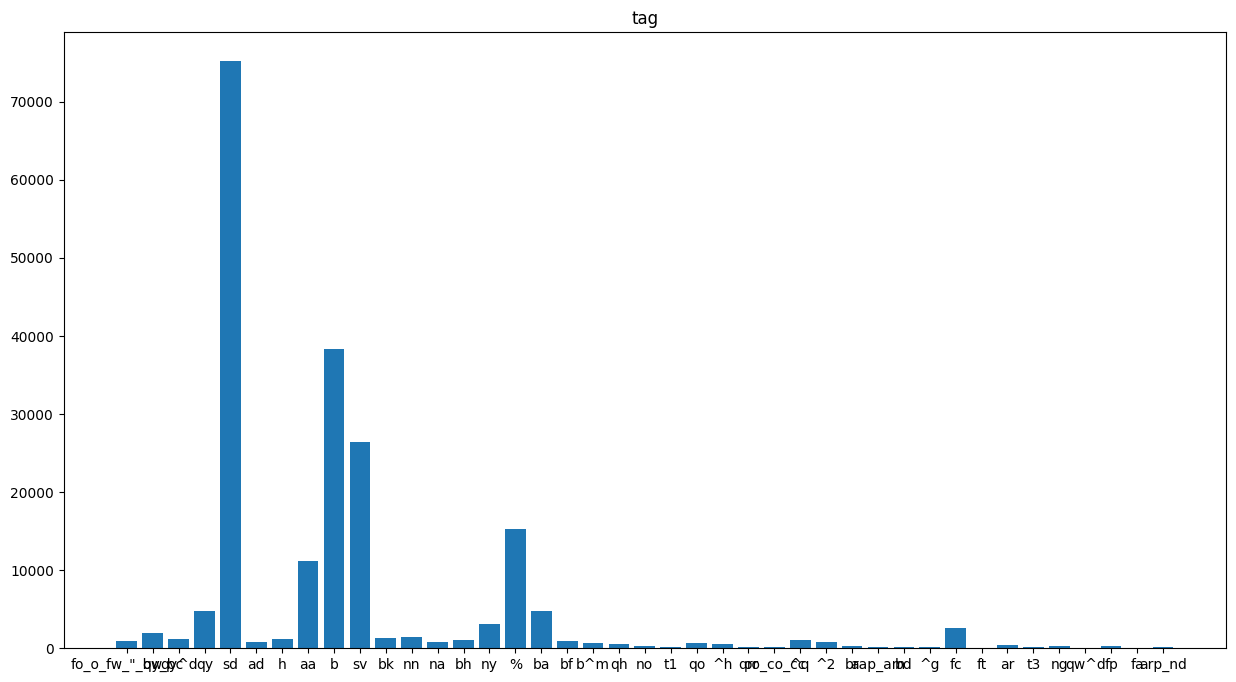

In [129]:
swdaData.tagDistribution()

In [130]:
swdaData.tagsMeaning("sd")

{'tag': 'sd',
 'meaning': 'Statement-non-opinion',
 'example': " Me,  I'm in the legal department.",
 'count': '72,824 ',
 '%': '36%'}

# unittests:

In [136]:
class TestDatasetClasses(unittest.TestCase):
    def testInstances(self):
        """Проверка на то, являются ли mrdaData и swdaData экземплярами соотвествующих классов."""
        self.assertIsInstance(mrdaData, MRDACorpus)
        self.assertNotIsInstance(mrdaData, SWDACorpus)
        self.assertIsInstance(swdaData, SWDACorpus)
        self.assertNotIsInstance(swdaData, MRDACorpus)
        self.assertIsInstance(mrdaData, BaseGetData)
        self.assertIsInstance(swdaData, BaseGetData)
    
    def testColumns(self):
        """Проверка на наличие названий колонок датафреймов."""
        self.assertIsNotNone(mrdaData.columns)
        self.assertIsNotNone(swdaData.columns)
    
    def testCountStats(self):
        """Проверка того, считается ли статистика по корпусам."""
        self.assertIsNotNone(mrdaData.countStats)
        self.assertIsNotNone(swdaData.countStats)

    def testStatsResults(self):
        """Проверка правильности подсчета статистики по корпусам (числа взяты из описаний корпусов авторами)."""
        self.assertEqual(mrdaData.countStats()["dialogues"], 75)
        self.assertEqual(mrdaData.countStats()["utterances"], 108202)
        self.assertEqual(np.round(mrdaData.countStats()["mean_dialogue_len"], 1), 1442.7)
        self.assertEqual(swdaData.countStats()["dialogues"], 1155)
        self.assertEqual(swdaData.countStats()["utterances"], 199736)
        self.assertEqual(np.round(swdaData.countStats()["mean_dialogue_len"], 1), 172.9)
    
    def testTagsMeaning(self):
        """Проверка правильности работы функции с описанием таксономии."""
        self.assertIsNotNone(mrdaData.tagsMeaning("^h"))
        self.assertIsNone(mrdaData.tagsMeaning("aaa"))

In [137]:
unittest.main(argv=[''], verbosity=2, exit=False)

testColumns (__main__.TestDatasetClasses)
Проверка на наличие названий колонок датафреймов. ... ok
testCountStats (__main__.TestDatasetClasses)
Проверка того, считается ли статистика по корпусам. ... ok
testInstances (__main__.TestDatasetClasses)
Проверка на то, являются ли mrdaData и swdaData экземплярами соотвествующих классов. ... ok
testStatsResults (__main__.TestDatasetClasses)
Проверка правильности подсчета статистики по корпусам (числа взяты из описаний корпусов авторами). ... ok
testTagsMeaning (__main__.TestDatasetClasses)
Проверка правильности работы функции с описанием таксономии. ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.078s

OK
